Context-dependent integration (CDI) task:
* White noise inputs for each context
* Context input, determining which of the signals should be integrated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind")
sns.set_context("poster")

import torch
device = torch.device("cpu")
dtype = torch.float

## Task

In [2]:
K = 2 # number of contexts
T = 30 # number of time steps
mu_hi, mu_lo = 1, -1 # For each trial, noise distribution is sampled from unif[mu_lo, mu_hi]
# Training params
batch_size = 64

In [3]:
def gen_batch(batch_size, seed = None, tensor_out = True):
    rng = np.random.RandomState(seed)
    context = rng.choice(np.arange(K), size=(batch_size))
    # Generate different mu per trial and per context:
    mu = rng.uniform(mu_lo, mu_hi, size=(batch_size, 1, K))
    Xcontext = np.zeros((batch_size, T, K))
    Xnoise = rng.normal(loc=mu, scale=1, size=(batch_size,T,K))
    Y = np.zeros((batch_size, T))
    for i in range(batch_size): # TO DO: vectorize
        Y[i] = np.cumsum(Xnoise[i,:,context[i]])
        Xcontext[i,:,context[i]] = 1
    if tensor_out:
        return torch.tensor(Xnoise, dtype=dtype,device=device), torch.tensor(Xcontext, dtype=dtype,device=device), torch.tensor(Y,dtype=dtype,device=device), mu
    else:
        return Xnoise, Xcontext, Y, mu

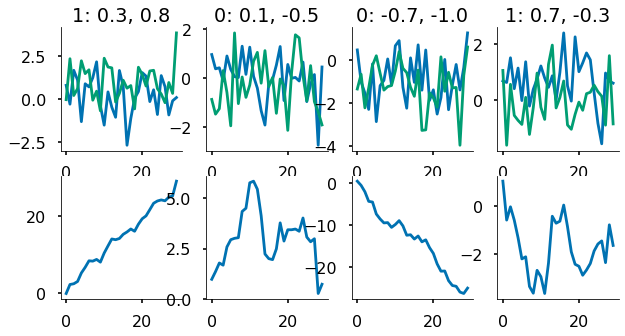

In [5]:
X, Xcontext, Y, mu= gen_batch(64, None,False)
n_show = 4
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i in range(n_show):
    ax[0,i].plot(X[i])
    ax[0,i].set_title("%u: %0.1f, %0.1f"%(np.argmax(Xcontext[i,0]),mu[i,0,0], mu[i,0,1]))
    ax[1,i].plot(Y[i])
sns.despine()

## Network
Vanilla RNN, LSTM,... 

In [6]:
   def __init__(self, mode, input_size, hidden_size,
                 num_layers=1, bias=True, batch_first=False,
                 dropout=0., bidirectional=False):
        super(RNNBase, self).__init__()

In [7]:
from torch import nn
n = 128 # hidden

In [135]:
class RNN(nn.Module):
    def __init__(self, n_in, n_rec, seed = None, f = torch.tanh):
        super(RNN, self).__init__()
        rng = np.random.RandomState(seed)
        self.Win = torch.nn.Parameter(torch.tensor(
                rng.normal(scale=1/np.sqrt(n_in), size=(n_in,n_rec)), 
                dtype=dtype,device=device))
        self.Wrec = torch.nn.Parameter(torch.tensor(
                rng.normal(scale=1/np.sqrt(n_rec), size=(n_rec, n_rec)), 
                dtype=dtype,device=device))
        self.Wout = torch.nn.Parameter(torch.tensor(
                rng.normal(scale=1/np.sqrt(n_rec), size=(n_rec, )), 
                dtype=dtype,device=device))
        self.b = torch.nn.Parameter(torch.tensor(
                np.zeros((n_rec,)), 
                dtype=dtype, device=device))
        self.f = f # nonlinearity
        
    def forward(self, X, ht = None):
        """ Forward prop
        Inputs:
        X of shape (batch_size, time_steps, input_dim),
        ht: initial state (batch_size, hidden_dim)
        input dim should be 2*K, first K contain noise, second K context 
        Returns:
        y: network output (batch_size, time_steps, )
        h: hiddens (batch_size,time_steps, rec_dim)
        """
        h = []
        batch_size, time_steps = X.shape[:2]
        if ht is None:
            ht = torch.zeros((batch_size, self.Wrec.shape[0]))
        for t in range(time_steps):
            at = torch.mm(X[:,t], self.Win) + torch.mm(ht, self.Wrec) + self.b
            ht = self.f(at)
            h.append(ht)
        h = torch.stack(h, 1)
        y = torch.einsum("abc,c->ab",h,self.Wout) #(batch_size, time_steps, rec dim) * (rec_dim, out_dim)
        return y,h

In [136]:
X, Xcontext, Y, mu= gen_batch(64, None,True)
X = torch.cat((X, Xcontext),-1)

## Training

TO DO: 
* sgd w/ momentum
* lr decay
* Other hyperparams
* Select best over 30 different inits

In [142]:
lr = 5e-4
n_epochs = 10000
loss_fn = torch.nn.MSELoss()
rnn = RNN(2*K, n)
optim = torch.optim.Adam(rnn.parameters(),lr)
loss_hist = []

0 97.27887725830078
1000 1.851771354675293
2000 0.55205237865448
3000 0.5958454608917236
4000 0.2599405348300934
5000 0.2220526784658432
6000 0.2862405478954315
7000 0.10109271854162216
8000 0.2701658606529236
9000 0.10477402806282043


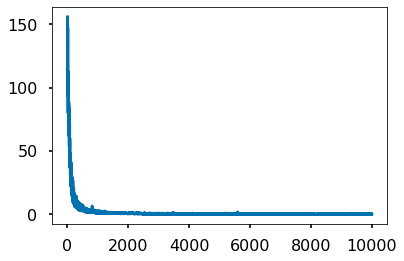

In [143]:
for epoch in range(n_epochs):
    X, Xcontext, Y, mu= gen_batch(batch_size)
    X = torch.cat((X, Xcontext),-1)
    Yhat, _ = rnn(X)
    loss = loss_fn(Y, Yhat)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if epoch % 1000 == 0:
        print(epoch, loss.item())
    loss_hist.append(loss.item())
plt.plot(loss_hist)

Test by sampling a new batch

In [144]:
Xn, Xctx, Y, mu= gen_batch(batch_size)
X = torch.cat((Xn, Xctx),-1)
Yhat, _ = rnn(X)

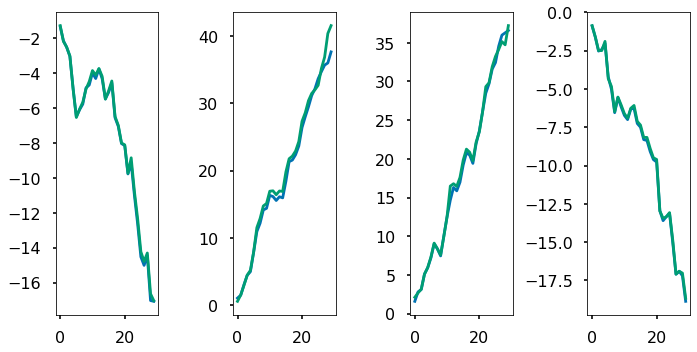

In [145]:
n_show = 4
f, ax = plt.subplots(1, n_show, figsize=(10,5))
for i in range(n_show):
    ctx = np.argmax(Xcontext[i,:,])
    ax[i].plot(Yhat[i].detach().numpy())
    ax[i].plot(Y[i].detach().numpy())
f.tight_layout()

## Reverse engineer:
1. Spectrum
2. PCA 
3. Fixed points
4. SVCCA
5. MDS

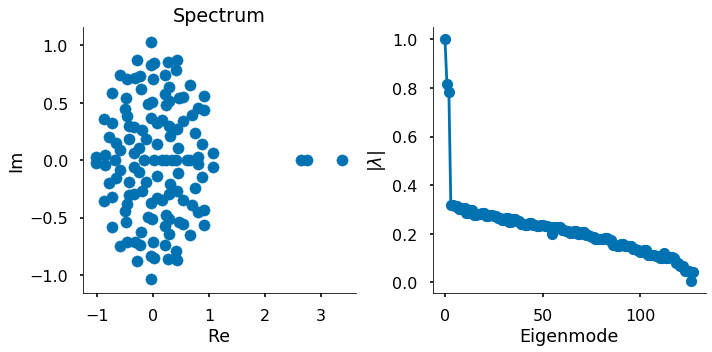

In [146]:
W = rnn.Wrec.detach().numpy()
x = np.linalg.eigvals(W)
f, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(np.real(x), np.imag(x))
ax[0].set_title("Spectrum")
ax[0].set_xlabel("Re")
ax[0].set_ylabel("Im")

scree = np.abs(x) / np.sum(np.abs(x))
ax[1].plot(scree / scree[0], 'o-')
ax[1].set_xlabel("Eigenmode")
ax[1].set_ylabel(r"$|\lambda|$")

f.tight_layout()
sns.despine()

In [345]:
# PCA for a single context
mu = np.arange(-1, 1, 0.1)
X = torch.zeros((mu.shape[0], T, 4))
X[:,:,0] = torch.tensor(mu[:,None], dtype=dtype,device=device)
X[:,:,2] = 1
y, h = rnn(X)
from sklearn.decomposition import PCA
pca = PCA()
H = pca.fit_transform(h.detach().numpy().reshape((-1, rnn.Wrec.shape[0]))).reshape((h.shape[0], -1, rnn.Wrec.shape[0]))

In [390]:
cmap = plt.cm.get_cmap("RdYlBu", h.shape[0])

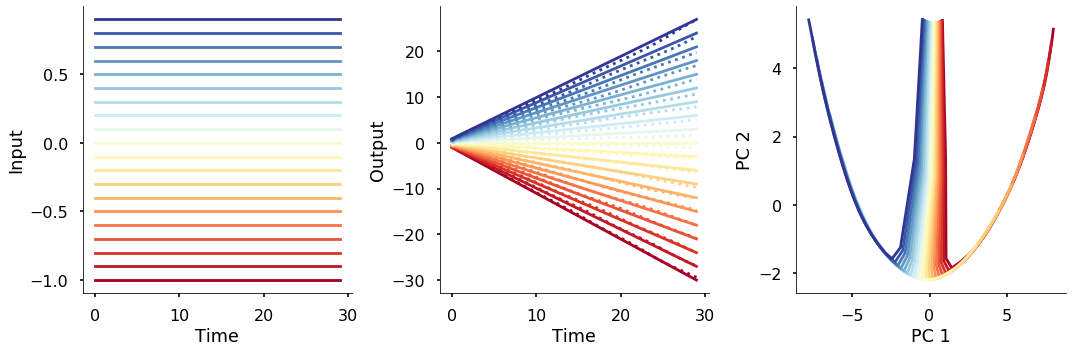

In [392]:
f, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(h.shape[0]):
    ax[0].plot(X[i,:,0].detach().numpy(), c=cmap(i))
    ax[1].plot(np.cumsum(X[i,:,0].detach().numpy()), c=cmap(i))
    ax[1].plot(y[i].detach().numpy(), ":", c=cmap(i),)
    ax[2].plot(H[i,:,0], H[i,:,1], c=cmap(i))
    
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Output")
ax[2].set_xlabel("PC 1")
ax[2].set_ylabel("PC 2")
f.tight_layout()
sns.despine()
plt.savefig("../figures/cdi_vanilla", dpi=300)

## Fixed Points
* Function computing loss 
$$| \dot{x}|^2 = | h_1 - h_0 |^2$$
* minimize loss over h(0). Set noise input to 0, fix one context
* Find all candidates and save their speed. 
* Discard 'same' candidates 

In [393]:
# Typical hidden states to start from
X, Xcontext, Y, mu= gen_batch(batch_size)
X = torch.cat((X, Xcontext),-1)
_, h = rnn(X)

In [394]:
def find_fpt(h0, tol = 1e-4):
    """ Find fixed point by starting at h0
    """
    h0 = torch.nn.Parameter(torch.tensor(h0.detach().numpy(), dtype=dtype,device=device)) # candidate
    print(h0.shape)
    optim = torch.optim.Adam([h0], lr=1e-3)
    x = torch.zeros((h0.shape[0], 1, 4))
    print(h0.shape,x.shape)
    x[:,:,2] = 1
    n_epochs = 5000
    loss_hist = []
    for epoch in range(n_epochs):
        h1 = rnn.f(torch.mm(x[:,0], rnn.Win) + torch.mm(h0, rnn.Wrec) + rnn.b)
        loss = loss_fn(h0, h1)
        optim.zero_grad()
        loss.backward() 
        optim.step()
        loss_hist.append(loss.item())
        if loss.item() < tol:
            break
    speeds = (h1 - h0).pow(2).mean(1)
    # Exclude points that are 
    return speeds, h0

152 non-unique candidates


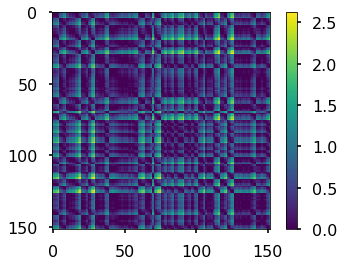

In [395]:
tol = 1e-4
unique_tol = 0.01
h0_slow = h0_new[speeds < tol]
speeds_slow = speeds[speeds < tol]
print("%u non-unique candidates"%h0_slow.shape[0])
diff = (h0_slow[:,:,None] - h0_slow.t()[None]).pow(2).mean(1)
plt.imshow(diff.detach().numpy())
plt.colorbar()

In [396]:
unique_fpts = np.ones(h0_slow.shape[0])
for i in range(h0_slow.shape[0]):
    if unique_fpts[i] == 1: # it's unique, throw away others
        for j in np.arange(i+1, h0_slow.shape[0]):
            if diff[i,j] <  unique_tol:
                unique_fpts[j] = 0
print("%u unique fixed points remaining"%np.sum(unique_fpts))
h0_unique = h0_slow[np.where(unique_fpts)]
speeds_unique = speeds_slow[np.where(unique_fpts)]

22 unique fixed points remaining


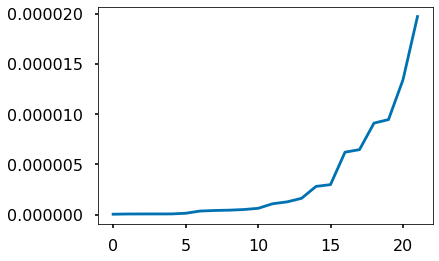

In [397]:
plt.plot(np.sort(speeds_unique.detach().numpy()))

In [398]:
# PCA for a single context
mu = np.arange(-1, 1, 0.1)
X = torch.zeros((mu.shape[0], T, 4))
X[:,:,0] = torch.tensor(mu[:,None], dtype=dtype,device=device)
X[:,:,2] = 1
y, h = rnn(X)
from sklearn.decomposition import PCA
pca = PCA()
H = pca.fit_transform(h.detach().numpy().reshape((-1, rnn.Wrec.shape[0]))).reshape((h.shape[0], -1, rnn.Wrec.shape[0]))
Hslow = pca.transform(h0_unique.detach().numpy())

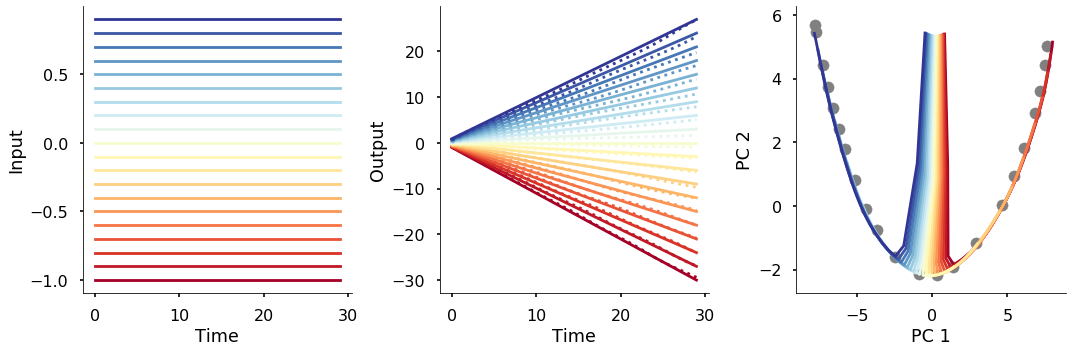

In [399]:
f, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(h.shape[0]):
    ax[0].plot(X[i,:,0].detach().numpy(), c=cmap(i))
    ax[1].plot(np.cumsum(X[i,:,0].detach().numpy()), c=cmap(i))
    ax[1].plot(y[i].detach().numpy(), ":", c=cmap(i),)
    ax[2].plot(H[i,:,0], H[i,:,1], c=cmap(i))
ax[2].scatter(Hslow[:,0], Hslow[:,1], color='gray')

ax[0].set_xlabel("Time")
ax[0].set_ylabel("Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Output")
ax[2].set_xlabel("PC 1")
ax[2].set_ylabel("PC 2")
f.tight_layout()
sns.despine()
plt.savefig("../figures/cdi_vanilla_fpts", dpi=300)

## Fixed point topology
Build graph based on transition probability between fixed points. Initialize hidden state close to hidden (hyper param: noise), run until convergence, observe how often state transitions to other fixed point.
Discard networks with different number of fixed point than mode. 

In [404]:
nfix = h0_unique.shape[0]
nrec = h0_unique.shape[1]

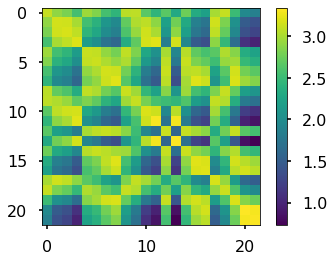

In [438]:
eps = 0.00001
hinit = (h0_unique + torch.randn(h0_unique.shape) * eps)
diff = (h0_unique[:,:,None] + hinit.t()[None]).pow(2).mean(1)
plt.imshow(diff.detach().numpy())
plt.colorbar()

torch.Size([22, 128]) torch.Size([22, 10, 4])


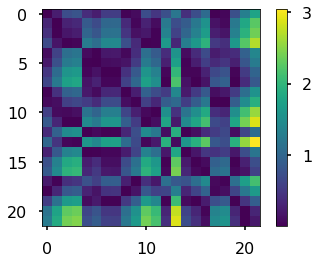

In [441]:
eps = 1 #how far from the fixed point?
hinit = (h0_unique + torch.randn(h0_unique.shape) * eps)
x = torch.zeros((hinit.shape[0], 10, 4)) # Run for 10 time steps
print(hinit.shape,x.shape)
x[:,:,2] = 1
_, htrajectory = rnn.forward(x, hinit)
# map to fixed points
diff = (h0_unique[:,:,None] - htrajectory[:,-1].t()[None]).pow(2).mean(1)
plt.imshow(diff.detach().numpy())
plt.colorbar()

In [473]:
T = np.zeros((nfix, nfix))
reps = 1000
eps = 0.1
for r in range(reps):
    hinit = (h0_unique + torch.randn(h0_unique.shape) * eps)
    x = torch.zeros((hinit.shape[0], 10, 4)) # Run for 10 time steps
    x[:,:,2] = 1
    _, htrajectory = rnn.forward(x, hinit)
    hfinal = htrajectory[:,-1]
    diff = (h0_unique[:,:,None] - htrajectory[:,-1].t()[None]).pow(2).mean(1)
    final_point = np.argmin(diff.detach().numpy(),1) # Closest fixed
    for i in range(nfix):
        T[i,final_point[i]] += 1

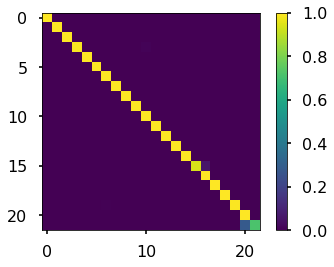

In [475]:
# All fixed points, except last two (they're not unique, perhaps)
plt.imshow(T / reps)
plt.colorbar()

## Linear predictions

Keep number of modes

## Linear predictions pt 2

For each fixed point: compute Jacobian dF/dh, with 

torch.Size([22, 128, 128])


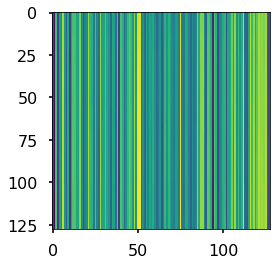

In [748]:
J = torch.zeros((h0_unique.shape[0], 128,128)) # will hold 
x = torch.zeros((h0_unique.shape[0], 1, 4)) # Run for 10 time steps
x[:,:,2] = 1
h0_unique.detach_().requires_grad_(True)
for j in range(128):
    hnew = rnn.f(torch.mm(x[:,0], rnn.Win) + torch.mm(h0_unique, rnn.Wrec) + rnn.b)
    e = torch.zeros((128,1)) # grad wrt jth output
    e[j] = 1
    out = torch.mm(hnew, e).mean()
    out.backward() 
    #hnew.mean(1).backward(e)
    J[:,j] = h0_unique.grad # (128)
print(J.shape)
plt.imshow(J[0])

In [742]:
# Linear prediction

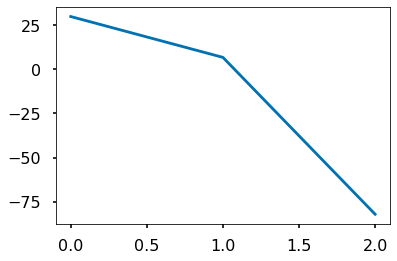

In [744]:
# first fixed point, unit magnitude input
x = torch.zeros((h0_unique.shape[0], 10, 4)) 
x[:,0,0] = 1 # input 1
x[:,:,2] = 1 #fixed context
i = -1
h = h0_unique[i]
hrec = [h]
for t in range(2):
    # Run linearlized dynamics
    h = h0_unique[i] + torch.mm(J[i], (h - h0_unique[i][:,None]))[:,0] + torch.mm(x[i,t][None], rnn.Win)[0] 
    hrec.append(h)
hrec = torch.stack(hrec,1)
out = torch.mm(rnn.Wout[None,], hrec)
plt.plot(out.detach().numpy().flatten())

In [610]:
# first fixed point, unit magnitude input
x = torch.zeros((h0_unique.shape[0], 10, 4)) 
x[:,0,2] = 1
hrec = []
for t in range(10):
    if t == 0:
        h = rnn.f(torch.mm(x[:,0], rnn.Win) + torch.mm(h0_unique, rnn.Wrec) + rnn.b)
    else:
         h = rnn.f(torch.mm(x[:,0], rnn.Win) + torch.mm(h, rnn.Wrec) + rnn.b)
y = torch.mm(h, rnn.Wout[:,None])

In [589]:
from scipy import linalg
linalg.eig(J)

In [ ]:
np.linalg.eig(J)

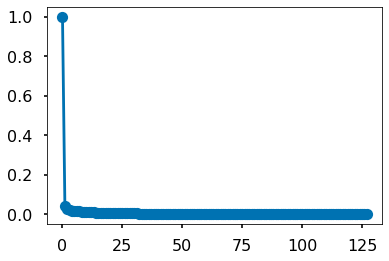

In [587]:
evals = np.linalg.eigvals(J[0])
plt.plot(np.abs(evals) / np.abs(evals[0]),'o-')